# Nobel Attention Curves and Causal Analysis

This notebook does the core analysis of the project. The code below buils Nobel Attention Curves to examine the causal effect of the Nobel Prize announcement on Wikipedia pageview traffic for economists.

The goal is to determine whether pageviews significantly respond to the Nobel Prize announcement and, if so, how long that surge in attention persists.

**Table of Content**

1. [Library Imports](#sec1)
2. [Load Datasets](#sec2)
3. [Merge Pageviews with Nobel Info](#sec3)
4. [Event-Time Variable](#sec4)
5. [Aggregate Pageviews by Event Year](#sec5)
6. [Nobel Attention Curve](#sec6)
7. [Nobel vs. non-Nobel Economists](#sec7)

<a id="sec1"></a>
### Library Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a id="sec2"></a>
### Load Datasets

The code below loads the complete, final dataset (including the manually added Nobel winner flags from the previous step) and merges the economist-level metadata with the time-series pageview data.

In [6]:
econ = pd.read_csv("../Data/economists_cleaned.csv")
econ = econ[["name", "qid"]]

In [9]:
views = pd.read_csv("../Data/economists_monthly_pageviews_2017_2025.csv")

In [10]:
nobel = pd.read_csv("../Data/nobel_economists.csv")

<a id="sec3"></a>
### Merge Pageviews with Nobel Info

In [11]:
df = views.merge(
    nobel[["qid", "nobel_year"]],
    on="qid",
    how="left"
)

Create Nobel Indicator

In [12]:
df["is_nobel"] = df["nobel_year"].notna()

In [15]:
df["year"] = df["date"] // 100
df["month"] = df["date"] % 100

<a id="sec4"></a>
### Event-Time Variable

A crucial step is creating the 'event-time' variable. This variable calculates the relative time to the Nobel Prize for winners only: ***event_year = year−nobel_year***
This formula allows the computation of relative time to Nobel (e.g., -3 years before, 0 during the Nobel year, and +2 years after).

In [21]:
df["month_index"] = df["year"] * 12 + df["month"]

In [23]:
df["nobel_month_index"] = df["nobel_year"] * 12 + 10

In [25]:
df["event_month"] = df["month_index"] - df["nobel_month_index"]

<a id="sec5"></a>
### Aggregate Pageviews by Event Year

In [27]:
event_window = df[
    (df["is_nobel"]) &
    (df["event_month"] >= -24) &
    (df["event_month"] <= 36)
]

In [29]:
attention_curve = (
    event_window
    .groupby("event_month")["views"]
    .mean()
    .reset_index()
)

<a id="sec6"></a>
### Nobel Attention Curve

This step uses the event_month variable to compute and plot the Nobel Attention Curve. The plot will visually demonstrate:

    - The average pageviews in the years preceding the announcement.
    - The sharp spike in pageviews during the Nobel year.
    - The decay of attention in the years following the announcement.

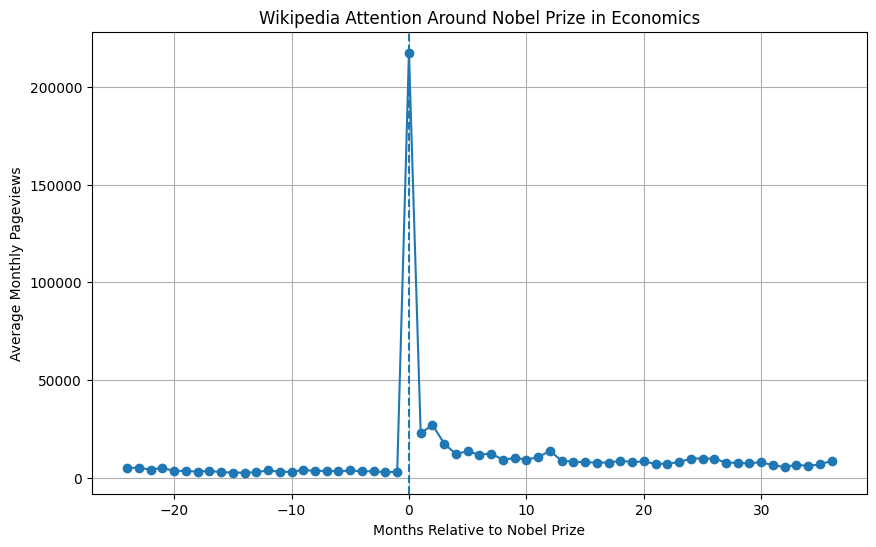

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    attention_curve["event_month"],
    attention_curve["views"],
    marker="o"
)

plt.axvline(0, linestyle="--")
plt.xlabel("Months Relative to Nobel Prize")
plt.ylabel("Average Monthly Pageviews")
plt.title("Wikipedia Attention Around Nobel Prize in Economics")
plt.grid(True)
plt.show()


<a id="sec7"></a>
### Nobel vs. non-Nobel Economists

The analysis concludes by generating a bar graph that compares the overall average monthly pageviews between Nobel-winning economists and non-Nobel economists.

In [31]:
monthly_avg = (
    df.groupby(["qid", "date"])["views"]
    .sum()
    .reset_index()
)

In [32]:
monthly_avg = monthly_avg.merge(
    df[["qid", "is_nobel"]].drop_duplicates(),
    on="qid",
    how="left"
)


In [33]:
comparison = (
    monthly_avg
    .groupby("is_nobel")["views"]
    .mean()
    .reset_index()
)

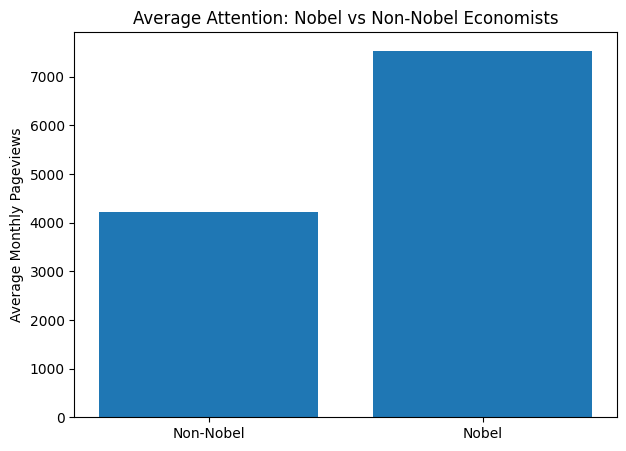

In [34]:
plt.figure(figsize=(7, 5))
plt.bar(
    comparison["is_nobel"].astype(str),
    comparison["views"]
)

plt.xticks([0, 1], ["Non-Nobel", "Nobel"])
plt.ylabel("Average Monthly Pageviews")
plt.title("Average Attention: Nobel vs Non-Nobel Economists")
plt.show()

In [35]:
attention_curve.to_csv("../Data/nobel_attention_curve_monthly.csv", index=False)
event_window.to_csv("../Data/nobel_event_window_raw.csv", index=False)